In [284]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [316]:
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    log_loss,
    roc_auc_score,
    classification_report,
    roc_curve,
    auc,
    make_scorer,
    recall_score,
    precision_recall_curve
)

import warnings
warnings.filterwarnings('ignore')


In [317]:
df = pd.read_csv('online_shoppers_intention.csv')
print(df.info())
df_c = df.copy()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False
5,0,0.0,0,0.0,19,154.216667,0.015789,0.024561,0.0,0.0,Feb,2,2,1,3,Returning_Visitor,False,False
6,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.0,0.4,Feb,2,4,3,3,Returning_Visitor,False,False
7,1,0.0,0,0.0,0,0.000000,0.200000,0.200000,0.0,0.0,Feb,1,2,1,5,Returning_Visitor,True,False
8,0,0.0,0,0.0,2,37.000000,0.000000,0.100000,0.0,0.8,Feb,2,2,2,3,Returning_Visitor,False,False
9,0,0.0,0,0.0,3,738.000000,0.000000,0.022222,0.0,0.4,Feb,2,4,1,2,Returning_Visitor,False,False


In [318]:
def create_target_var(df_in: pd.DataFrame) -> pd.DataFrame:
    print(50*"==")
    print("Purchase distribution before target:")
    print(df_in.groupby('Revenue')['Revenue'].count())
    df_out = df_in.copy()

    df_out['has_purchase'] = (
        df_out['Revenue'].apply(lambda x: 1 if x == True else 0)
    )

    print(50*"==")
    print("Purchase distribution after target:")
    print(df_out.groupby(['Revenue', 'has_purchase'])['Revenue'].count())
    df_out.drop(columns=['Revenue'], inplace=True)
    return df_out

# Transform target & other features
df = create_target_var(df)
df['Weekend'] = df['Weekend'].astype(int)
df.head(10)

Purchase distribution before target:
Revenue
False    10422
True      1908
Name: Revenue, dtype: int64
Purchase distribution after target:
Revenue  has_purchase
False    0               10422
True     1                1908
Name: Revenue, dtype: int64


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,has_purchase
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,0,0
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,0,0
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,0,0
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,0,0
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,1,0
5,0,0.0,0,0.0,19,154.216667,0.015789,0.024561,0.0,0.0,Feb,2,2,1,3,Returning_Visitor,0,0
6,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.0,0.4,Feb,2,4,3,3,Returning_Visitor,0,0
7,1,0.0,0,0.0,0,0.000000,0.200000,0.200000,0.0,0.0,Feb,1,2,1,5,Returning_Visitor,1,0
8,0,0.0,0,0.0,2,37.000000,0.000000,0.100000,0.0,0.8,Feb,2,2,2,3,Returning_Visitor,0,0
9,0,0.0,0,0.0,3,738.000000,0.000000,0.022222,0.0,0.4,Feb,2,4,1,2,Returning_Visitor,0,0


### Train/Val/Test Split

In [319]:
TARGET = 'has_purchase'
X = df.drop(columns=[TARGET])
y = df[TARGET]

In [320]:
# Create a 60/20/20 split & stratify target to ensure balanced distr across datasets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=42
)

print(f'Training set: X: {X_train.shape}, y: {y_train.shape}')
print(f'Validation set: X: {X_val.shape}, y: {y_val.shape}')
print(f'Test set: X: {X_test.shape}, y: {y_test.shape}')

Training set: X: (7398, 17), y: (7398,)
Validation set: X: (2466, 17), y: (2466,)
Test set: X: (2466, 17), y: (2466,)


### Preprocessing

In [321]:
NUM_FEATURES = [
    'Administrative_Duration',
    'Informational_Duration',
    'ProductRelated',
    'ProductRelated_Duration',
    'BounceRates',
    'ExitRates',
    'PageValues'
]

CAT_FEATURES = [
    'Weekend',
    'VisitorType',
    'SpecialDay',
    'OperatingSystems',
    'Region',
    'Month',
    'Browser',
    'Informational',
    'TrafficType',
    'Administrative'
]

In [322]:
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train[NUM_FEATURES])
X_val_num_scaled = scaler.transform(X_val[NUM_FEATURES])
X_test_num_scaled = scaler.transform(X_test[NUM_FEATURES])
print('Example:', X_train_num_scaled[0])

Example: [ 0.09644267 -0.24500419 -0.6050983  -0.57172529 -0.46469129 -0.38617724
 -0.3150239 ]


In [323]:
X_train_num_scaled_df = pd.DataFrame(X_train_num_scaled, columns=NUM_FEATURES, index=X_train.index)
X_val_num_scaled_df = pd.DataFrame(X_val_num_scaled, columns=NUM_FEATURES, index=X_val.index)
X_test_num_scaled_df = pd.DataFrame(X_test_num_scaled, columns=NUM_FEATURES, index=X_test.index)

X_train_num_scaled_df.head()

,Administrative_Duration,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues
6996,0.096443,-0.245004,-0.605098,-0.571725,-0.464691,-0.386177,-0.315024
4306,-0.438978,-0.245004,-0.396390,-0.417240,-0.085274,0.033320,-0.315024
4767,-0.438978,-0.245004,-0.303631,-0.488031,0.282287,0.363410,-0.315024
11274,0.701117,0.518446,0.531203,0.861792,-0.464691,-0.456760,-0.315024
6612,-0.438978,-0.245004,-0.002163,-0.350795,-0.464691,-0.756941,-0.315024


In [324]:
ENCODED_FEATURES = [i for i in CAT_FEATURES if i != 'Weekend']

encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

X_train_cat_encoded = encoder.fit_transform(X_train[ENCODED_FEATURES])
X_val_cat_encoded = encoder.transform(X_val[ENCODED_FEATURES])
X_test_cat_encoded = encoder.transform(X_test[ENCODED_FEATURES])

encoded_cols = encoder.get_feature_names_out(ENCODED_FEATURES)

X_train_encoded = pd.DataFrame(X_train_cat_encoded, columns=encoded_cols, index=X_train.index)
X_val_encoded = pd.DataFrame(X_val_cat_encoded, columns=encoded_cols, index=X_val.index)
X_test_encoded = pd.DataFrame(X_test_cat_encoded, columns=encoded_cols, index=X_test.index)

In [325]:
# Combine numeric + encoded categorical features
X_train_final = pd.concat([X_train_num_scaled_df, X_train_encoded, X_train[['Weekend']]], axis=1)
X_val_final = pd.concat([X_val_num_scaled_df, X_val_encoded, X_val[['Weekend']]], axis=1)
X_test_final = pd.concat([X_test_num_scaled_df, X_test_encoded, X_test[['Weekend']]], axis=1)

X_train_final.head()

,Administrative_Duration,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,VisitorType_Other,VisitorType_Returning_Visitor,SpecialDay_0.2,...,Administrative_16,Administrative_17,Administrative_18,Administrative_19,Administrative_20,Administrative_21,Administrative_22,Administrative_23,Administrative_24,Weekend
6996,0.096443,-0.245004,-0.605098,-0.571725,-0.464691,-0.386177,-0.315024,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4306,-0.438978,-0.245004,-0.396390,-0.417240,-0.085274,0.033320,-0.315024,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4767,-0.438978,-0.245004,-0.303631,-0.488031,0.282287,0.363410,-0.315024,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
11274,0.701117,0.518446,0.531203,0.861792,-0.464691,-0.456760,-0.315024,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
6612,-0.438978,-0.245004,-0.002163,-0.350795,-0.464691,-0.756941,-0.315024,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [326]:
assert all(X_train_final.columns == X_val_final.columns)
assert all(X_train_final.columns == X_test_final.columns)

In [327]:
def calculate_class_weights(y):
    # Count number of samples per class
    counts = y.value_counts()
    total = len(y)

    proportions = {c: counts.get(c, 0) / total for c in [0, 1]}
    print('class_weight current:', proportions)

    inverted = {c: 1 / p if p > 0 else 0 for c, p in proportions.items()}
    total_inv = sum(inverted.values())
    class_weight = {c: w / total_inv for c, w in inverted.items()}
    print(f'Balanced class weights (for model): {class_weight}')
    return class_weight


X_train_class_weight = calculate_class_weights(y_train)
X_train_class_weight

class_weight current: {0: 0.845228440118951, 1: 0.15477155988104893}
Balanced class weights (for model): {0: 0.15477155988104893, 1: 0.845228440118951}


{0: 0.15477155988104893, 1: 0.845228440118951}

### Model Training

#### Logistic Regression

In [328]:
model = LogisticRegression(
    max_iter=1000,
    class_weight=X_train_class_weight,
)

model.fit(X_train_final, y_train)
y_train_pred = model.predict(X_train_final)
y_train_probs = model.predict_proba(X_train_final)[:,1]

In [329]:
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Create labeled matrix
    labels = [
        [f"TN = {tn}\n(True Neg)", f"FP = {fp}\n(False Pos)"],
        [f"FN = {fn}\n(False Neg)", f"TP = {tp}\n(True Pos)"]
    ]

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False,
                xticklabels=['Pred: 0 (Basic)', 'Pred: 1 (Luxury)'],
                yticklabels=['Actual: 0 (Basic)', 'Actual: 1 (Luxury)'])

    plt.title(title, fontsize=14)
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

========= Train Set Evaluation =========


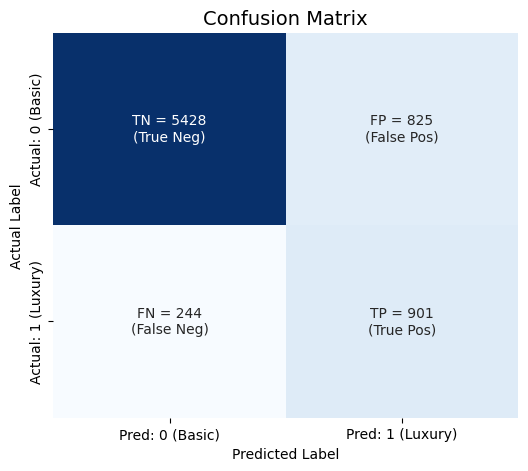

Accuracy: 0.8555014868883482
Log-loss: 0.42518892612607356
ROC-AUC: 0.9154879020515567
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      6253
           1       0.52      0.79      0.63      1145

    accuracy                           0.86      7398
   macro avg       0.74      0.83      0.77      7398
weighted avg       0.89      0.86      0.87      7398



In [330]:
print("========= Train Set Evaluation =========")
# print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))
plot_confusion_matrix(y_train, y_train_pred)
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("Log-loss:", log_loss(y_train, y_train_probs))
print("ROC-AUC:", roc_auc_score(y_train, y_train_probs))
print(classification_report(y_train, y_train_pred))

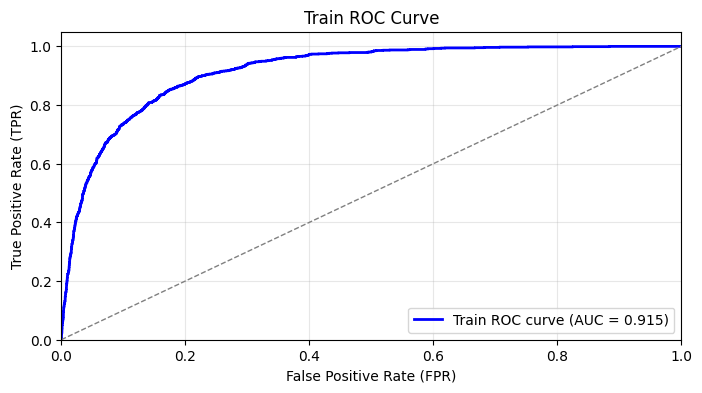

In [331]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_train, y_train_probs)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Train ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--') #, label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Train ROC Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

In [332]:
y_val_pred = model.predict(X_val_final)
y_val_probs = model.predict_proba(X_val_final)[:,1]

print("\n=== Validation Set Evaluation ===")
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Log-loss:", log_loss(y_val, y_val_probs))
print("ROC-AUC:", roc_auc_score(y_val, y_val_probs))


=== Validation Set Evaluation ===
Confusion Matrix:
 [[1767  318]
 [  80  301]]
Accuracy: 0.8386050283860503
Log-loss: 0.43803378064071125
ROC-AUC: 0.903670134758335


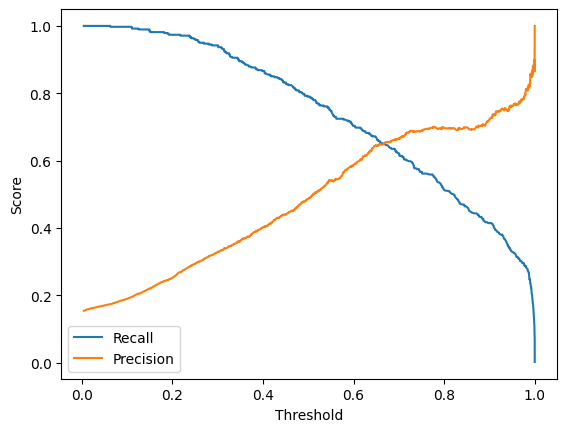

In [333]:
precision, recall, thresholds = precision_recall_curve(y_val, y_val_probs)
plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(thresholds, precision[:-1], label='Precision')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

Note:
 - In case we'd like to make the model favor more positive classes, we could tradeoff higher recall and have lower precision.
 - This way we'll classify more correctly online purchases (or close to) and create more False Positives, but guarantee we capture online purchasers

#### RandomForestClassifier

In [334]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

In [335]:
rf_model.fit(X_train_final, y_train)
y_train_pred = rf_model.predict(X_train_final)
y_train_probs = rf_model.predict_proba(X_train_final)[:,1]

========= Train Set Evaluation =========


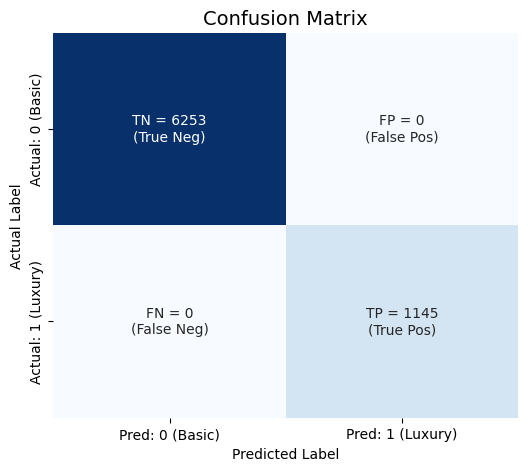

Accuracy: 1.0
Log-loss: 0.06236519315263512
ROC-AUC: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6253
           1       1.00      1.00      1.00      1145

    accuracy                           1.00      7398
   macro avg       1.00      1.00      1.00      7398
weighted avg       1.00      1.00      1.00      7398



In [336]:
print("========= Train Set Evaluation =========")
# print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))
plot_confusion_matrix(y_train, y_train_pred)
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("Log-loss:", log_loss(y_train, y_train_probs))
print("ROC-AUC:", roc_auc_score(y_train, y_train_probs))
print(classification_report(y_train, y_train_pred))

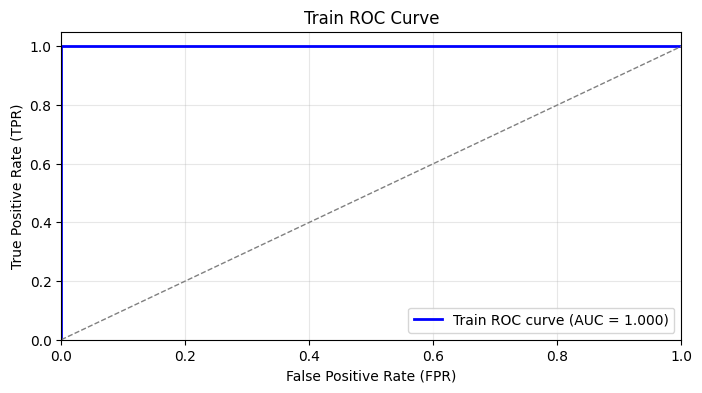

In [337]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_train, y_train_probs)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Train ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--') #, label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Train ROC Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

In [338]:
y_val_pred = rf_model.predict(X_val_final)
y_val_probs = rf_model.predict_proba(X_val_final)[:,1]

print("\n=== Validation Set Evaluation ===")
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Log-loss:", log_loss(y_val, y_val_probs))
print("ROC-AUC:", roc_auc_score(y_val, y_val_probs))


=== Validation Set Evaluation ===
Confusion Matrix:
 [[2019   66]
 [ 179  202]]
Accuracy: 0.9006488240064883
Log-loss: 0.23684925504722967
ROC-AUC: 0.9293925489529634


#### XGBoost

In [339]:
counter = Counter(y_train)

xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=counter[0] / counter[1]
)

xgb_model.fit(X_train_final, y_train)
y_train_pred = xgb_model.predict(X_train_final)
y_train_probs = xgb_model.predict_proba(X_train_final)[:,1]

========= Train Set Evaluation =========


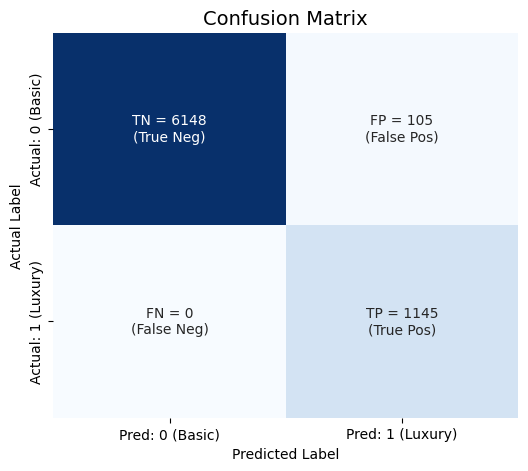

Accuracy: 0.9858069748580698
Log-loss: 0.07142834561632921
ROC-AUC: 0.9995463487569635
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      6253
           1       0.92      1.00      0.96      1145

    accuracy                           0.99      7398
   macro avg       0.96      0.99      0.97      7398
weighted avg       0.99      0.99      0.99      7398



In [340]:
print("========= Train Set Evaluation =========")
# print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))
plot_confusion_matrix(y_train, y_train_pred)
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("Log-loss:", log_loss(y_train, y_train_probs))
print("ROC-AUC:", roc_auc_score(y_train, y_train_probs))
print(classification_report(y_train, y_train_pred))

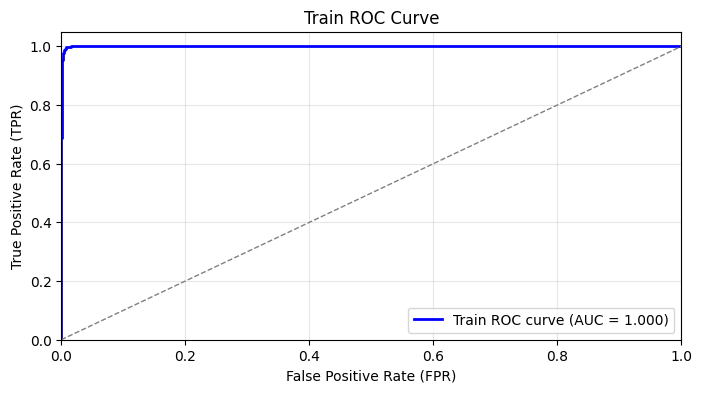

In [341]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_train, y_train_probs)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Train ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--') #, label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Train ROC Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

In [342]:
y_val_pred = xgb_model.predict(X_val_final)
y_val_probs = xgb_model.predict_proba(X_val_final)[:,1]

print("\n=== Validation Set Evaluation ===")
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Log-loss:", log_loss(y_val, y_val_probs))
print("ROC-AUC:", roc_auc_score(y_val, y_val_probs))


=== Validation Set Evaluation ===
Confusion Matrix:
 [[1897  188]
 [ 101  280]]
Accuracy: 0.8828061638280617
Log-loss: 0.28979371923217895
ROC-AUC: 0.9215556688507461


### Feature Importance

In [343]:
feature_names = X_train_final.columns

Top 10 Features
PageValues          2.213938
TrafficType_8       0.938788
Month_Nov           0.732361
TrafficType_20      0.709928
TrafficType_11      0.692151
Informational_5     0.684720
TrafficType_5       0.622089
Informational_9     0.561338
Administrative_6    0.537518
Administrative_8    0.533032
dtype: float64


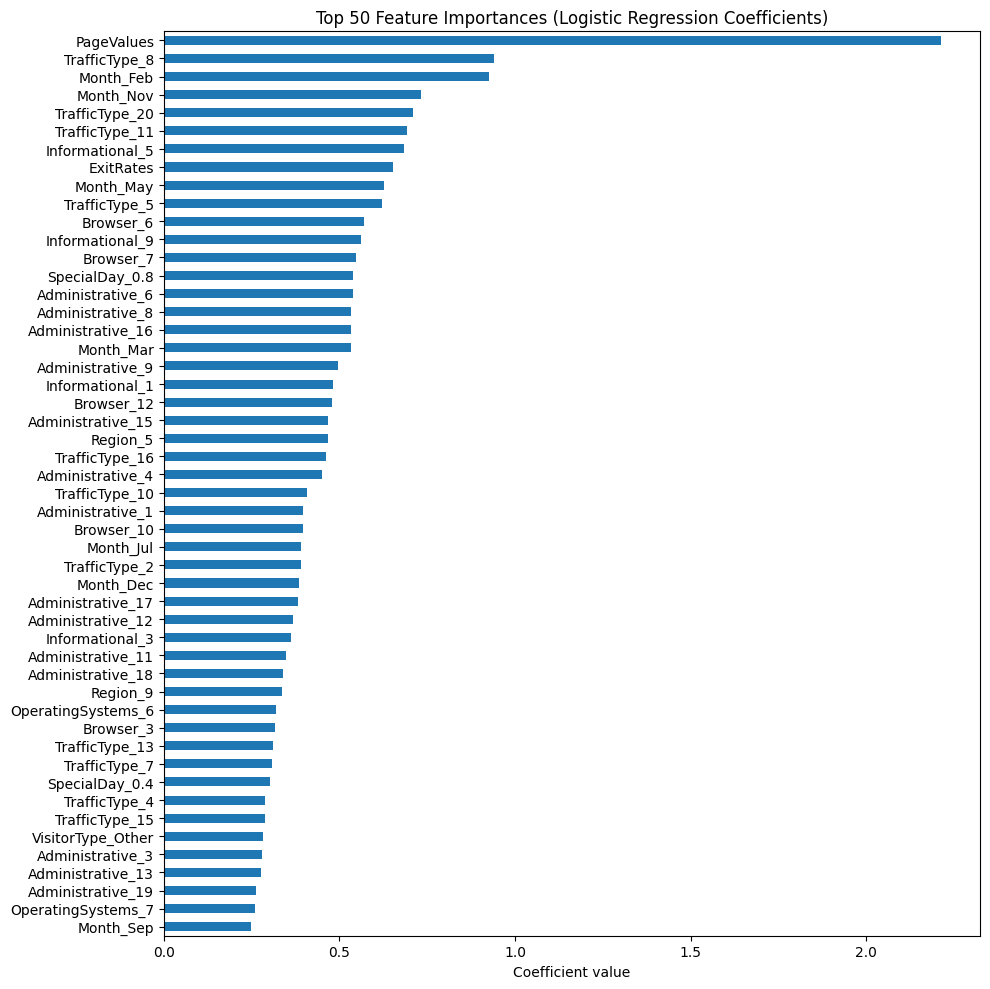

In [344]:
feature_importance = pd.Series(
    model.coef_[0],
    index=feature_names
).sort_values(ascending=False)

print('Top 10 Features')
print(feature_importance.head(10))

plt.figure(figsize=(10, 10))
# feature_importance.head(50).plot(kind='barh')
feature_importance.abs().sort_values(ascending=False).head(50).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 50 Feature Importances (Logistic Regression Coefficients)")
plt.xlabel("Coefficient value")
plt.tight_layout()
plt.show()

### Hyperparameter Tunning

#### Logistic Regression

In [345]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
best_auc = 0
best_C = None

for C in param_grid['C']:
    temp_model = LogisticRegression(max_iter=1000, class_weight=X_train_class_weight, C=C)
    temp_model.fit(X_train_final, y_train)
    y_val_probs_temp = temp_model.predict_proba(X_val_final)[:,1]
    auc = roc_auc_score(y_val, y_val_probs_temp)
    print(f"C={C} -> Validation ROC-AUC: {auc:.4f}")
    if auc > best_auc:
        best_auc = auc
        best_C = C

print(f"Best C on validation set: {best_C}, ROC-AUC={best_auc:.4f}")

C=0.001 -> Validation ROC-AUC: 0.8922
C=0.01 -> Validation ROC-AUC: 0.9052
C=0.1 -> Validation ROC-AUC: 0.9084
C=1 -> Validation ROC-AUC: 0.9037
C=10 -> Validation ROC-AUC: 0.8996
Best C on validation set: 0.1, ROC-AUC=0.9084


#### RandomForestClassifier

In [346]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['sqrt', 'log2', 0.5],  # number or fraction of features
    'bootstrap': [True, False]
}

rf_model = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')

# ROC-AUC scorer
roc_auc = make_scorer(roc_auc_score)

# Randomized search
rf_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid,
    n_iter=50,                  # number of random combinations
    scoring=roc_auc,
    cv=5,                       # 5-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1
)

rf_search.fit(X_train_final, y_train)

print("Best hyperparameters:", rf_search.best_params_)
print("Best CV ROC-AUC:", rf_search.best_score_)

# Best model
best_rf = rf_search.best_estimator_

y_val_pred = best_rf.predict_proba(X_val_final)[:, 1]
y_test_pred = best_rf.predict_proba(X_test_final)[:, 1]

print("Validation ROC-AUC:", roc_auc_score(y_val, y_val_pred))
print("Test ROC-AUC:", roc_auc_score(y_test, y_test_pred))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 'log2', 'max_depth': 15, 'bootstrap': False}
Best CV ROC-AUC: 0.8551938070155229
Validation ROC-AUC: 0.9224859482492745
Test ROC-AUC: 0.9065166162534796


#### XGBoost

In [347]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 5, 10],
    'gamma': [0, 0.1, 0.2]  # minimum loss reduction for split
}

xgb_model = XGBClassifier(
    use_label_encoder=False,  # avoids warning
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=counter[0]/counter[1]
)

roc_auc = make_scorer(roc_auc_score)

xgb_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=50,
    scoring=roc_auc,
    cv=5,
    verbose=1,      # reduce massive logs
    random_state=42,
    n_jobs=-1
)

xgb_search.fit(X_train_final, y_train)

best_xgb = xgb_search.best_estimator_

print("Best hyperparameters:", xgb_search.best_params_)
print("Best CV ROC-AUC:", xgb_search.best_score_)

# Optional: evaluate on validation and test
y_val_pred = best_xgb.predict_proba(X_val_final)[:, 1]
y_test_pred = best_xgb.predict_proba(X_test_final)[:, 1]

print("Validation ROC-AUC:", roc_auc_score(y_val, y_val_pred))
print("Test ROC-AUC:", roc_auc_score(y_test, y_test_pred))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/sebastianmedina/anaconda3/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [23:18:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sebastianmedina/anaconda3/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [23:18:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sebastianmedina/anaconda3/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [23:18:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sebastianmedina/anaconda3/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [23:18:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters:

Best hyperparameters: {'subsample': 0.6, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 0.8}
Best CV ROC-AUC: 0.8571073079702177
Validation ROC-AUC: 0.9350705262561604
Test ROC-AUC: 0.9289324798263507


### Retrain Models with best parameters

In [348]:
X_full_train = pd.concat([X_train_final, X_val_final], axis=0)
y_full_train = pd.concat([y_train, y_val], axis=0)

print(X_full_train.shape)
print(y_full_train.shape)

(9864, 109)
(9864,)


In [349]:
class_weights_final = calculate_class_weights(y_full_train)

class_weight current: {0: 0.8452960259529603, 1: 0.15470397404703973}
Balanced class weights (for model): {0: 0.15470397404703973, 1: 0.8452960259529602}


In [350]:
lr_model = LogisticRegression(
    max_iter=1000,
    class_weight=class_weights_final,
    C=0.1
)


rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    random_state=42,
    n_jobs=-1,
    max_features='log2',
    min_samples_leaf=10,
    min_samples_split=2,
    bootstrap=False,
    class_weight='balanced'
)


counter = Counter(y_full_train)
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=counter[0] / counter[1],
    subsample=0.6,
    n_estimators=200,
    max_depth=3,
    learning_rate=0.05,
    gamma=0.2,
    colsample_bytree=0.8
)


# Create an empty dataframe first with all the columns
model_summary_df = pd.DataFrame(columns=[
    'model',
    'train_accuracy',
    'train_log_loss',
    'train_roc_auc',
    'train_recall_positive_class',
    'test_accuracy',
    'test_log_loss',
    'test_roc_auc',
    'test_recall_positive_class'
])

In [355]:
def model_train_test_eval(model, model_name):
    model.fit(X_full_train, y_full_train)

    # Predict on full train set
    y_train_pred = model.predict(X_full_train)
    y_train_probs = model.predict_proba(X_full_train)[:,1]
    # Predict on test set
    y_test_pred = model.predict(X_test_final)
    y_test_probs = model.predict_proba(X_test_final)[:,1]

    return pd.DataFrame([{
        'model': model_name,
        'train_accuracy': round(accuracy_score(y_full_train, y_train_pred), 4),
        'train_log_loss': round(log_loss(y_full_train, y_train_probs), 4),
        'train_roc_auc': round(roc_auc_score(y_full_train, y_train_probs), 4),
        'train_recall_positive_class': round(recall_score(y_full_train, y_train_pred, pos_label=1), 4),
        'test_accuracy': round(accuracy_score(y_test, y_test_pred), 4),
        'test_log_loss': round(log_loss(y_test, y_test_probs), 4),
        'test_roc_auc': round(roc_auc_score(y_test, y_test_probs), 4),
        'test_recall_positive_class': round(recall_score(y_test, y_test_pred, pos_label=1), 4),
    }])

In [357]:
model_summary_df = pd.concat([
    model_train_test_eval(lr_model, 'LogisticRegression'),
    model_train_test_eval(rf_model, 'RandomForestClassifier'),
    model_train_test_eval(xgb_model, 'XGBoost')
], ignore_index=True)

In [359]:
model_summary_df

,model,train_accuracy,train_log_loss,train_roc_auc,train_recall_positive_class,test_accuracy,test_log_loss,test_roc_auc,test_recall_positive_class
0,LogisticRegression,0.8625,0.4246,0.9127,0.7733,0.8459,0.4455,0.8960,0.7225
1,RandomForestClassifier,0.8679,0.3866,0.9532,0.9043,0.8516,0.4172,0.9083,0.8351
2,XGBoost,0.8722,0.3027,0.9496,0.8742,0.8597,0.3286,0.9293,0.8455


 - We could potentially improve the models further. But this leaves us with a good subset.
 - XGBoost seems like a good option if we care about Recall and make sure we capture as many online purchasers as possible.